# Logistic Falkon 1D data

In [2]:
import os
import sys

import time
import torch
import falkon
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, model_selection
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import chi2
from datetime import datetime

import mplhep as hep
hep.style.use(hep.style.CMS)
# plt.style.use('ggplot')

# sys.path.insert(0, "../data")
from plot_utils import plot_ref_data, plot_ref_data_reco, plot_loss_history, plot_one_t, plot_two_t


In [3]:
from falkon import LogisticFalkon
from falkon.kernels import GaussianKernel
from falkon.options import FalkonOptions
from falkon.gsc_losses import WeightedCrossEntropyLoss

## Define class

In [4]:
def normalize(X):
    """Standardize dataset
    Args:
        X (np.ndarray): Original Dataset
    Returns:
        np.ndarray: Normalized Dataset
    """    
    X_norm = X.copy()
    
    for j in range(X_norm.shape[1]):
        column = X_norm[:, j]

        mean = np.mean(column)
        std = np.std(column)
    
        if np.min(column) < 0:
            column = (column-mean)*1./ std
        elif np.max(column) > 1.0:                                                                                                                                        
            column = column *1./ mean
    
        X_norm[:, j] = column
    
    return X_norm
    

def normalize_features(reference, data):
    """
    Normalize features (higgs normalization)

    Parameters
    ----------
    reference : np.ndarray
        Numpy array reference sample
    data : np.ndarray
        Numpy array data sample

    Returns
    -------
    ref_norm : np.ndarray
        Normalized Numpy array reference sample
    data_norm : np.ndarray
        Normalized Numpy array data sample

    """
    
    X_norm = normalize(np.vstack((reference, data)))
    
    ref_size = reference.shape[0]
    
    ref_norm = X_norm[:ref_size, :]
    data_norm = X_norm[ref_size:, :]
    
    return ref_norm, data_norm

def generate_data(N_REF, N_BKG, N_SIG, SIG_LOC, SIG_STD, normalize=False):
    """Generate synthetic data for training and testing a machine learning model.

    Args:
        config_json (dict): A dictionary containing the configuration parameters for generating the data.

    Returns:
        tuple: A tuple containing the feature tensor and target tensor.
            The feature tensor has shape (N_samples, N_features) and contains the input features for each sample.
            The target tensor has shape (N_samples, 2) and contains the target labels and weights for each sample.
    """
    
    # poisson fluctuate the number of events in each sample
    N_bkg_p = int(torch.distributions.Poisson(rate=N_BKG).sample())
    N_sig_p = int(torch.distributions.Poisson(rate=N_SIG).sample())
    
    # the reference rate will not have nuisance parameters
    feature_ref_dist = torch.distributions.Exponential(rate=1)

    # the data rate will have nuisance parameters   
    feature_bkg_dist = torch.distributions.Exponential(rate=1)
    feature_sig_dist = torch.distributions.Normal(loc=SIG_LOC, scale=SIG_STD)
    
    # generate the features
    feature_ref  = feature_ref_dist.sample((N_REF, 1))
    feature_data = torch.cat(
        (
            feature_bkg_dist.sample((N_bkg_p, 1)),
            feature_sig_dist.sample((N_sig_p, 1))
        )
    )

    # concatenate the features
    feature = torch.cat((feature_ref, feature_data), dim=0)

    # generate the target
    target_ref  = torch.zeros((N_REF, 1))
    target_data = torch.ones((N_bkg_p + N_sig_p, 1))

    target = torch.cat((target_ref, target_data), dim=0)
    
    # if normalize:
    #     feature = norm_func(feature)
 
    return feature_ref, target_data, target_ref, target_data

In [4]:
# model_parameters = {
#     'sigma' : 0.3, # kernel lengthscale
#     'penalty_list' : [1e-7], # list of regularization parameters,
#     'iter_list' : [1000], #list of number of CG iterations,
#     'M' : 3000, #number of Nystrom centers,
#     'keops_active': "pyKeOPS", # optional, if it is used, pyKeOPS is used to speed-up computations
#     'seed' : None # (int or None), the model seed (used for Nystrom center selection) is manually set.
#  }
# data_params = {
#     "N_REF"   : 200000,
#     "N_BKG"   : 2000,
#     "N_SIG"   : 0,
#     "SIG_LOC" : 6.4,
#     "SIG_STD" : 0.16,
# }
# kernel = GaussianKernel(torch.Tensor([model_parameters["sigma"]]))
# cg_tol = 1e-7
# keops_active = "auto"
# use_cpu = False
# weight = data_params["N_BKG"] / data_params["N_REF"]
# configuration = {
#     'kernel' : kernel,
#     'penalty_list' : model_parameters["penalty_list"],
#     'iter_list' : model_parameters["iter_list"],
#     'M' : model_parameters["M"],
#     'options' : FalkonOptions(cg_tolerance=cg_tol, keops_active=keops_active, use_cpu=use_cpu, debug = False),
#     'loss' : WeightedCrossEntropyLoss(kernel=kernel, neg_weight=weight),
#     'seed' : model_parameters["seed"]
# }

# HEPMODEL

In [5]:
sys.path.insert(0, "nn_models")
from LogFalkonHep import LogFalkonHEPModel

In [25]:
model_parameters = {
    'sigma' : 2.3, # kernel lengthscale
    'penalty_list' : [1e-5], # list of regularization parameters,
    'iter_list' : [100_000], #list of number of CG iterations,
    'M' : 3000, #number of Nystrom centers,
    'keops_active': "no", # optional, if it is used, pyKeOPS is used to speed-up computations
    'seed' : None, # (intor None), the model seed (used for Nystrom center selection) is manually set.
    'cg_tol' : np.sqrt(1e-7), # CG tolerance
    'use_cpu' : False # if falkon will be executed in cpu (optional, default False)
 }

data_params = {
    "N_REF"   : 200000,
    "N_BKG"   : 2000,
    "N_SIG"   : 0,
    "SIG_LOC" : 6.4,
    "SIG_STD" : 0.16,
}

model = LogFalkonHEPModel(data_params)

In [27]:
t, x, y = model.learn_t(model_parameters)
print(t)

Iteration 0 - penalty 1.000000e-05 - sub-iterations 100000
6.132381439208984


In [15]:
toys = 25
t_list=[]

for toy in range(toys):
    model_parameters['seed'] = int(time.time())
    t, _, _ = model.learn_t(model_parameters)
    t_list.append(t)
    # print(model.model_seed)

Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000


Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000

## chi2 Fit

In [17]:
# t_list

In [18]:
df_fit, loc, scale = chi2.fit(t_list, floc=0, fscale=1)
print(df_fit)

7.562792968750015


In [21]:
t_ref_bins  = np.arange(0, 40, 4)
t_data_bins = np.arange(0, 40, 4)
xgrid_ref   = np.arange(0, 40, 0.5)
xgrid_data  = np.arange(0, 40, 0.5)

ref_dof  = 8.33
ref_chi2 = chi2(df=df_fit)

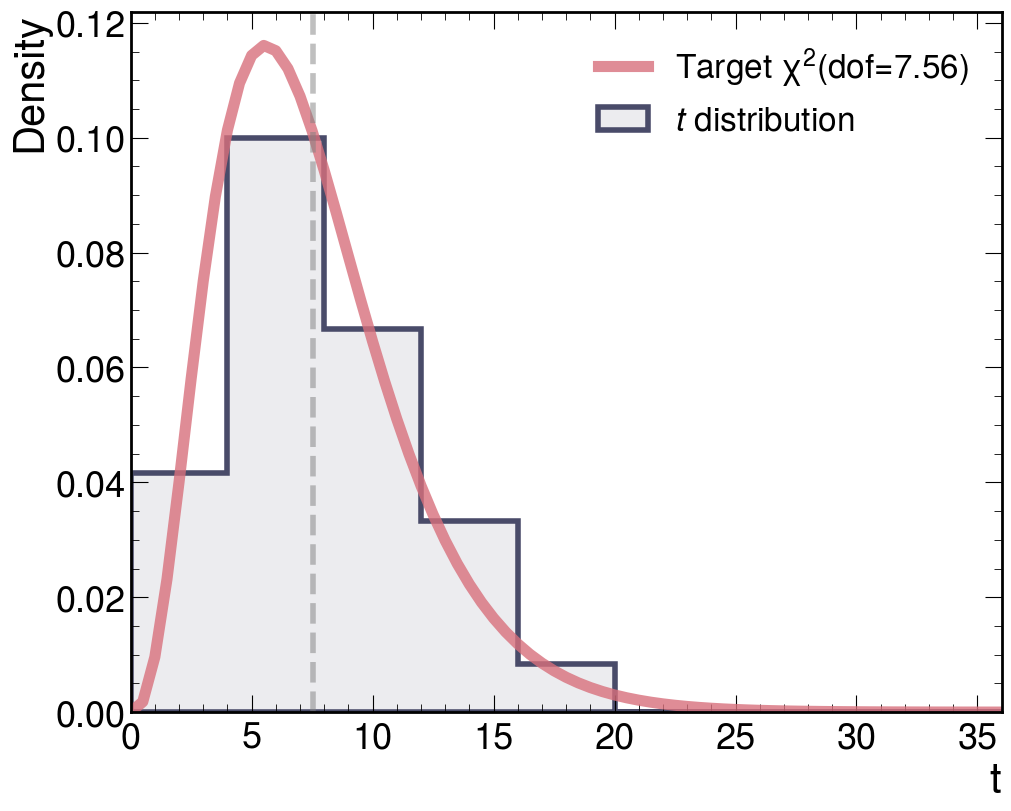

In [22]:
plot_one_t(
    t_distribution  = t_list,
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = (10, 8),
    fontsize        = 30,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = ("#494B69", 1.0),
    hist_fcolor     = ("#494B69", 0.1),
    chi2_color      = ("#D8707C", 0.8),
    hist_lw         = 4,
    chi2_lw         = 8,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%.2f)"%(df_fit),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution",
    # plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    plot_w          = False,
    wclip           = 2.6,
)


# Hyperparameters tuning

## sigma : pairwise distance

tensor(2.7048e-06)
tensor(11.7987)


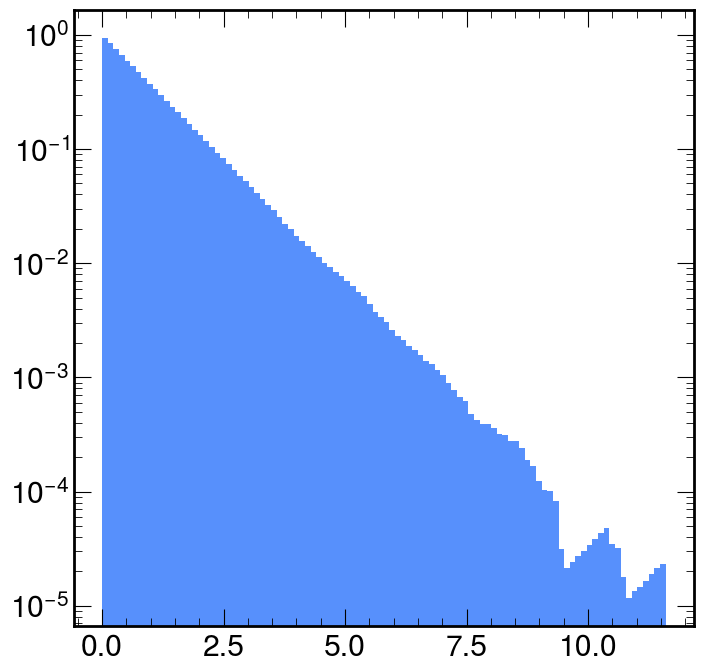

In [ ]:
print(x.min())
print(x.max())
data  = x[range(80_000)]

distances = pairwise_distances(data, metric='l2')

plt.figure(figsize=(8,8))
plt.hist(distances.ravel(), bins=100, density=True)
plt.yscale('log')
plt.show()

### 90% quantile

In [ ]:
print(np.quantile(distances, 0.90))
print(np.median(distances))
del distances

2.30414080619812
0.6938522


## M : number of centers

In [ ]:
model_parameters = {
    'sigma' : 2.3, # kernel lengthscale
    'penalty_list' : [1e-10], # list of regularization parameters,
    'iter_list' : [10_000], #list of number of CG iterations,
    'M' : 3000, #number of Nystrom centers,
    'keops_active': "no", # optional, if it is used, pyKeOPS is used to speed-up computations
    'seed' : None, # (intor None), the model seed (used for Nystrom center selection) is manually set.
    'cg_tol' : np.sqrt(1e-5), # CG tolerance
    'use_cpu' : False, # if falkon will be executed in cpu (optional, default False)
    'error_every' : 1
 }

data_params = {
    "N_REF"   : 200000,
    "N_BKG"   : 2000,
    "N_SIG"   : 0,
    "SIG_LOC" : 6.4,
    "SIG_STD" : 0.16,
}

model = LogFalkonHEPModel(data_params)

In [ ]:
model_parameters['M'] = 100
model_parameters['penalty_list'] = [1e-10]
t, x, y = model.learn_t(model_parameters)
print(t)

Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
9.604354858398438


In [ ]:
toys = 40
M_list   = [10, 100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 5000]
model_parameters['penalty_list'] = [1e-8] # list of regularization parameters,

t_M_list = []

for M in M_list:
    print(M)
    model_parameters['M'] = M # list of regularization parameters,
    t_list_tmp = []
    for toy in range(toys):
        model_parameters['seed'] = np.random.randint(low=0, high=2**32, dtype=int)
        t, _, _ = model.learn_t(model_parameters)
        t_list_tmp.append(t)

    t_M_list.append(t_list_tmp)
    del t_list_tmp
    
model_parameters['penalty_list'] = [1e-7] # list of regularization parameters,
t_M_list_8 = []
for M in M_list:
    print(M)
    model_parameters['M'] = M # list of regularization parameters,
    t_list_tmp = []
    for toy in range(toys):
        model_parameters['seed'] = np.random.randint(low=0, high=2**32, dtype=int)
        t, _, _ = model.learn_t(model_parameters)
        t_list_tmp.append(t)

    t_M_list_8.append(t_list_tmp)
    del t_list_tmp
    

10
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000


Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000
Iteration 0 - penalty 1.000000e

Text(0, 1, 'median t')

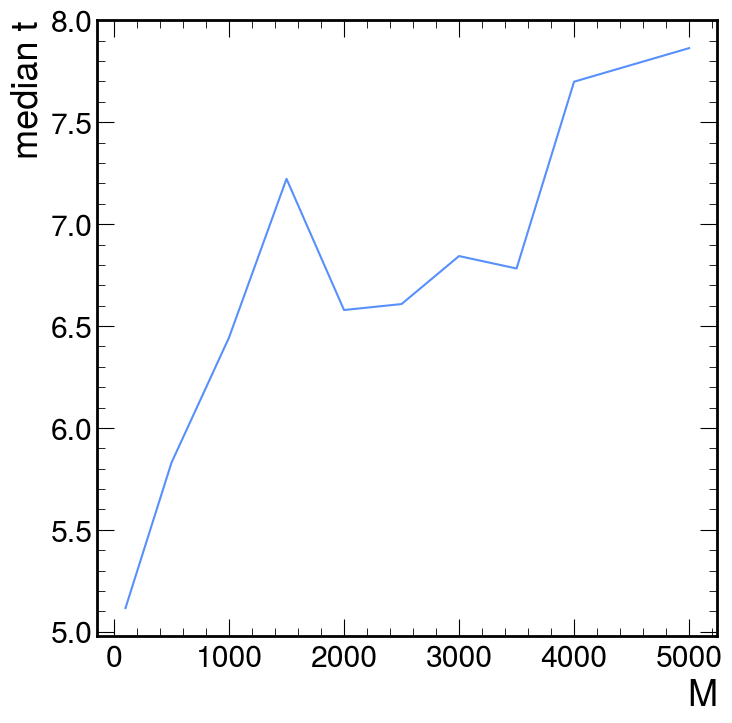

In [ ]:
t_median = [np.median(t_M_list[i]) for i in range(len(t_M_list)) if i!=0]
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(M_list[1:],t_median)
ax.set_xlabel('M')
ax.set_ylabel('median t')


Text(0, 1, 'median t')

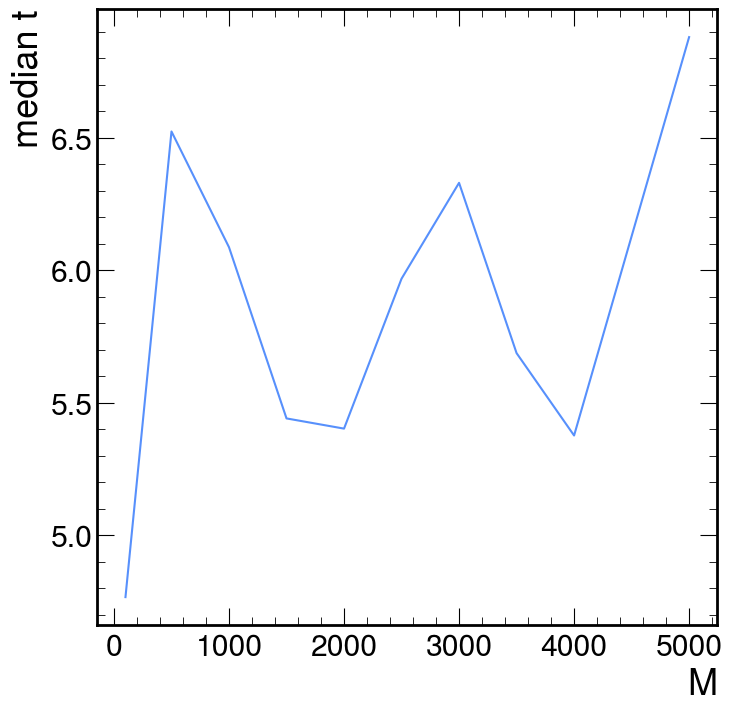

In [ ]:
t_median = [np.median(t_M_list_8[i]) for i in range(len(t_M_list_8)) if i!=0]
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(M_list[1:],t_median)
ax.set_xlabel('M')
ax.set_ylabel('median t')


3000


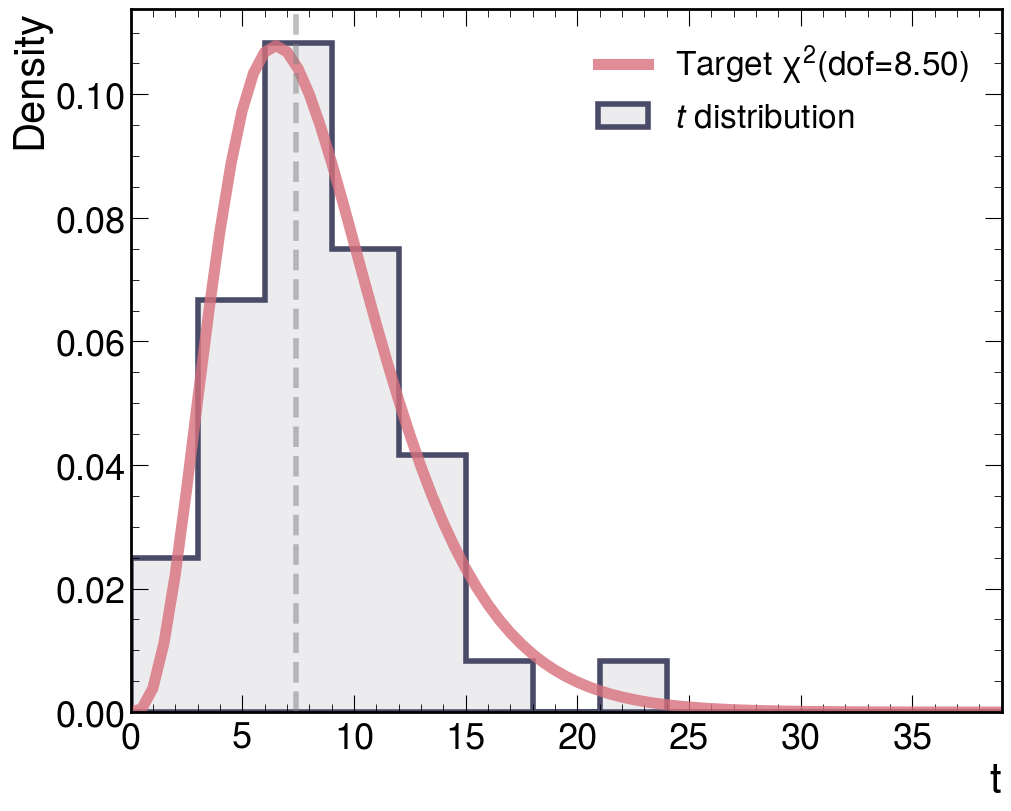

In [ ]:
idx=7
df_fit, loc, scale = chi2.fit(t_M_list[idx], floc=0, fscale=1)
t_ref_bins  = np.arange(0, 40, 3)
t_data_bins = np.arange(0, 40, 3)
xgrid_ref   = np.arange(0, 40, 0.5)
xgrid_data  = np.arange(0, 40, 0.5)
ref_chi2 = chi2(df=df_fit)
print(M_list[idx])
plot_one_t(
    t_distribution  = t_M_list[idx],
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = (10, 8),
    fontsize        = 30,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = ("#494B69", 1.0),
    hist_fcolor     = ("#494B69", 0.1),
    chi2_color      = ("#D8707C", 0.8),
    hist_lw         = 4,
    chi2_lw         = 8,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%.2f)"%(df_fit),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution",
    # plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    plot_w          = False,
    wclip           = 2.6,
)
